In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

sns_c = sns.color_palette(palette='deep')


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, ConstantKernel, DotProduct, RationalQuadratic, Matern, RationalQuadratic
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)



from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [8]:
df = pd.read_csv('Data/casos_diarios.csv')
df['t'] = [i + 1 for i in range(df.shape[0])]

df['media_movel_3'] = df['casos_diarios'].rolling(3).mean()
df['media_movel_7'] = df['casos_diarios'].rolling(7).mean()
df['media_movel_15'] = df['casos_diarios'].rolling(15).mean()

df['media_movel_30'] = df['casos_diarios'].rolling(30).mean()




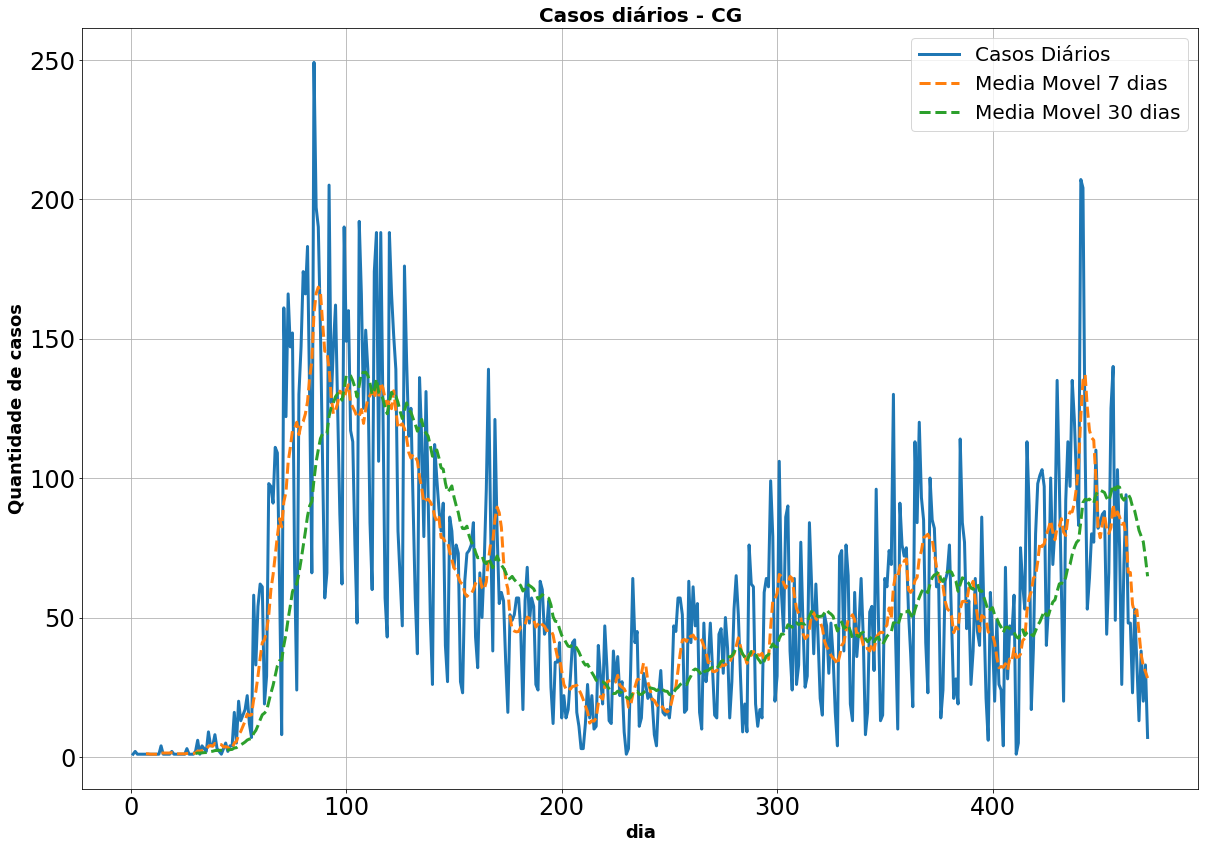

In [3]:
# Visualização dos dados

fig, ax = plt.subplots(figsize = (20,14))

ax.plot(df['t'], df['casos_diarios'], label = 'Casos Diários', linewidth = 3)

ax.plot(df['t'], df['media_movel_7'], '--', label = 'Media Movel 7 dias', linewidth = 3)

ax.plot(df['t'], df['media_movel_30'], '--', label = 'Media Movel 30 dias', linewidth = 3)

ax.set_title('Casos diários - CG', fontsize = 20, fontweight = 'bold')
ax.set_xlabel('dia', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Quantidade de casos', fontsize = 18, fontweight = 'bold')
ax.tick_params(axis='both', which='major', labelsize=24)
ax.legend(fontsize = 20)
ax.grid(True)

plt.show()

# Modelagem dos dados para previsão

No primeiro momento, vamos trabalhar com os dados de média móvel de casos de 7 dias. O objetivo vai ser prever a média móvel com janela de 7 dias, 7 dias para a frente. Seguimos com a modelagem:

In [12]:
df

,Data,casos_diarios,t,media_movel_3,media_movel_7,media_movel_15,media_movel_30,target,lag_feature_0,lag_feature_1,lag_feature_2,lag_feature_3,lag_feature_4,lag_feature_5,lag_feature_6
0,2020-01-02,1,1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-04,2,2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-06,1,3,1.333333,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-07,1,4,1.333333,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-09,1,5,1.000000,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,2021-06-27,13,468,33.333333,44.714286,64.400000,81.266667,NaN,52.714286,51.571429,54.714286,66.142857,66.285714,79.428571,83.857143
468,2021-06-28,38,469,28.333333,36.714286,62.533333,79.233333,NaN,44.714286,52.714286,51.571429,54.714286,66.142857,66.285714,79.428571
469,2021-06-29,20,470,23.666667,32.714286,55.533333,77.133333,NaN,36.714286,44.714286,52.714286,51.571429,54.714286,66.142857,66.285714
470,2021-06-30,33,471,30.333333,30.571429,48.400000,71.333333,NaN,32.714286,36.714286,44.714286,52.714286,51.571429,54.714286,66.142857


In [11]:
# Construindo o target
df['target'] = df['media_movel_7'].shift(-8)

# Construindo lag features
for i in range(7):
    df[f'lag_feature_{i}'] = df['media_movel_7'].shift(i+1)



# Análise dos dados

* Que features utilizaremos para realizar as previsões ?
* Como se comporta o dado que queremos prever ?
    * Existe sazonalidade? Existe tendência?
    * Analise os gráficos de ACF e PACF e a estacionariedade tanto dos casos diários quanto da médida móvel

Text(0.5, 1.0, 'Partial Autocorrelations')

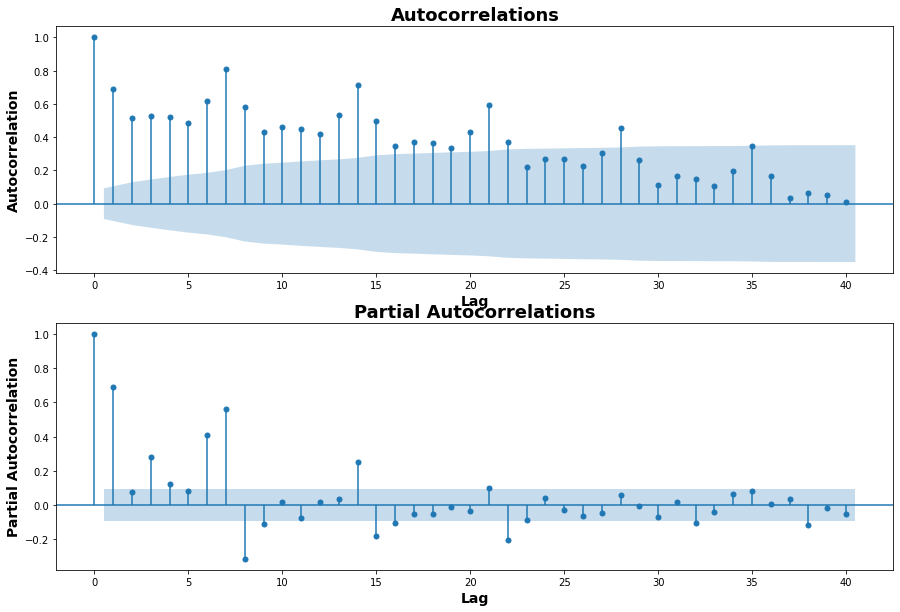

In [5]:
covid_cases = df.casos_diarios
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10))

acf_1 = plot_acf(covid_cases.values, lags=40, ax = axs[0])
pacf_1 = plot_pacf(covid_cases.values, lags=40, ax = axs[1])
axs[0].set_title('Autocorrelations', fontsize = 18, fontweight = 'bold')
axs[0].set_xlabel('Lag', fontsize = 14, fontweight = 'bold')
axs[0].set_ylabel('Autocorrelation', fontsize = 14, fontweight = 'bold')

axs[1].set_xlabel('Lag', fontsize = 14, fontweight = 'bold')
axs[1].set_ylabel('Partial Autocorrelation', fontsize = 14, fontweight = 'bold')
axs[1].set_title('Partial Autocorrelations', fontsize = 18, fontweight = 'bold')


Conforme mencionado pela professora Elloá, podemos ver existe uma sazonalidade semanal. Os casos aumentam ao longo da semana e diminuem no final de semana. Podemos utilizar novamente a média móvel dos casos nos últimos 7 dias, bem como a quantidade de casos no tempo t-7 e t-8. Vamos tentar observar como se comporta os casos dentro da semana.

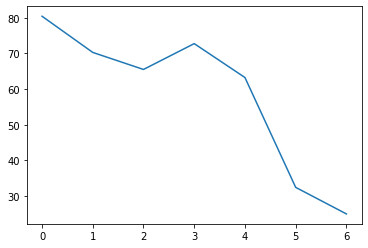

In [6]:
df['data'] = pd.to_datetime(df['Data'])
df['day_of_week'] = df['data'].dt.weekday
mean_week_day= df.groupby('day_of_week').agg({'casos_diarios':['mean']})
plt.plot(mean_week_day)

Text(0.5, 1.0, 'Partial Autocorrelations')

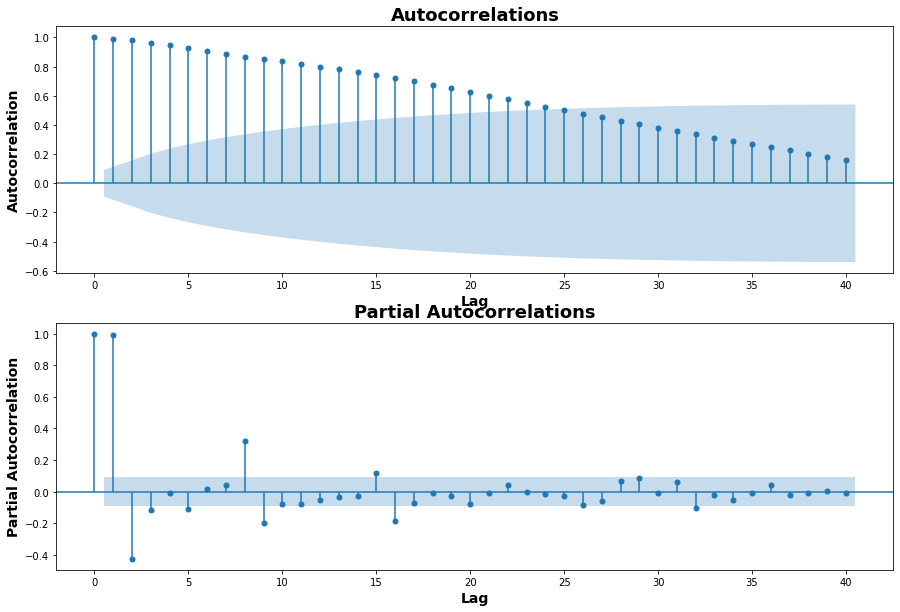

In [7]:
covid_cases = df.media_movel_7
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (15,10))

acf_1 = plot_acf(covid_cases.values, lags=40, ax = axs[0])
pacf_1 = plot_pacf(covid_cases.values, lags=40, ax = axs[1])
axs[0].set_title('Autocorrelations', fontsize = 18, fontweight = 'bold')
axs[0].set_xlabel('Lag', fontsize = 14, fontweight = 'bold')
axs[0].set_ylabel('Autocorrelation', fontsize = 14, fontweight = 'bold')

axs[1].set_xlabel('Lag', fontsize = 14, fontweight = 'bold')
axs[1].set_ylabel('Partial Autocorrelation', fontsize = 14, fontweight = 'bold')
axs[1].set_title('Partial Autocorrelations', fontsize = 18, fontweight = 'bold')


# Decomposição da série temporal

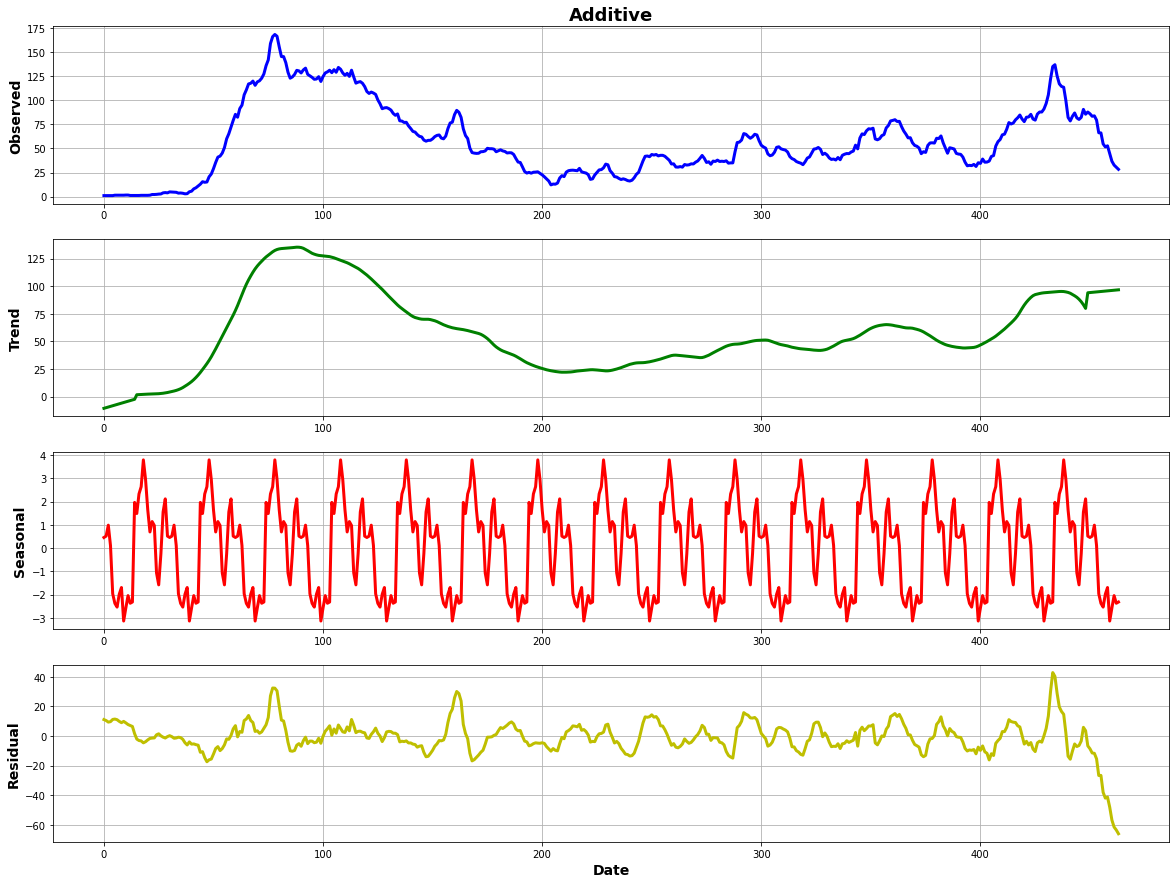

In [16]:
ts = df['target'].dropna()

# Decomposing using seasonal_decompose

result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq', period = 30)
#result_mult = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq', period = 1)

# Plot
fig, axs = plt.subplots(figsize = (20,15), nrows = 4, ncols = 1)


axs[0].plot(result_add.observed, linewidth = 3, color = 'b')
axs[0].set_ylabel('Observed', fontsize = 14, fontweight = 'bold')
axs[0].set_title('Additive', fontsize = 18, fontweight = 'bold')
axs[0].grid(True)


axs[1].plot(result_add.trend,linewidth = 3, color = 'g')
axs[1].set_ylabel('Trend', fontsize = 14, fontweight = 'bold')
axs[1].grid(True)

axs[2].plot(result_add.seasonal,linewidth = 3, color = 'r')
axs[2].set_ylabel('Seasonal', fontsize = 14, fontweight = 'bold')
axs[2].grid(True)

axs[3].plot(result_add.resid,linewidth = 3, color = 'y')
axs[3].set_ylabel('Residual', fontsize = 14, fontweight = 'bold')
axs[3].set_xlabel('Date', fontsize = 14, fontweight = 'bold')
axs[3].grid(True)


plt.show()


# Obtenção dos dados de treinamento

In [21]:

features = ['t', 'casos_diarios', 'lag_feature_1']
target = ['target']
train_df = df.dropna(subset = features + target)
X = np.array(train_df[features])

y = np.array(train_df['target']).reshape(-1,1)




# Definição de kernels com abordagem semi-paramétrica

In [47]:
# Regressão polinomial

semi_parametric_kernels = []

## Linear -- Não estacionário
linear_kernels = [DotProduct(sigma_0) for sigma_0 in range(1,10)]

#squared exponential

sqr_exp_kernels = [RBF(l) for l in np.logspace(-1, 1, 5)]

noise_kernels = [WhiteKernel()]

for lk in linear_kernels:
    for sek in sqr_exp_kernels:
        for nk in noise_kernels:
            semi_parametric_kernels.append(lk + sek + nk)

In [48]:
tscv = TimeSeriesSplit(n_splits=10)
model = GaussianProcessRegressor()
param_search = {'model__kernel': semi_parametric_kernels, 'model__alpha': [1e-2, 1e-3]}

training_pipeline = Pipeline([('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'mape': 'neg_mean_absolute_percentage_error'}


gsearch = GridSearchCV(estimator=training_pipeline, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = 'R2')

In [49]:
# Fit dos dados
gsearch.fit(X,y)  

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('model', GaussianProcessRegressor())]),
             param_grid={'model__alpha': [0.01, 0.001],
                         'model__kernel': [DotProduct(sigma_0=1) + RBF(length_scale=0.1) + WhiteKernel(noise_level=1),
                                           DotProduct(sigma_0=1) + RBF(length_scale=0.316) + WhiteKernel(noise_level=1...
                                           DotProduct(sigma_0=6) + RBF(length_scale=1) + WhiteKernel(noise_level=1),
                                           DotProduct(sigma_0=6) + RBF(length_scale=3.16) + WhiteKernel(noise_level=1),
                                           DotProduct(sigma_0=6) + RBF(length_scale=10) + WhiteKernel(noise_level=1), ...]},
             refit='R2',
             scoring={'R2': 'r2', 'mae': 'neg_mean_absolute_error',
                      'mape': 'neg_mean_absolute_percentage_error',
          

In [50]:
results = pd.DataFrame(gsearch.cv_results_)
results = results.sort_values(by='rank_test_R2')
results.reset_index(inplace= True, drop = True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__kernel,params,split0_test_R2,split1_test_R2,split2_test_R2,...,split3_test_mape,split4_test_mape,split5_test_mape,split6_test_mape,split7_test_mape,split8_test_mape,split9_test_mape,mean_test_mape,std_test_mape,rank_test_mape
0,0.649619,0.463477,0.003219,0.002120,0.001,DotProduct(sigma_0=9) + RBF(length_scale=1) + ...,"{'model__alpha': 0.001, 'model__kernel': DotPr...",-49.917102,-12.123598,-1.057858,...,-0.314236,-0.429278,-0.23537,-0.189176,-0.230684,-0.253717,-0.223437,-0.387567,0.299389,1
1,0.548396,0.313580,0.002390,0.000927,0.001,DotProduct(sigma_0=1) + RBF(length_scale=3.16)...,"{'model__alpha': 0.001, 'model__kernel': DotPr...",-49.917698,-12.123558,-1.057858,...,-0.314236,-0.429278,-0.23537,-0.189176,-0.230684,-0.253717,-0.223437,-0.387568,0.299391,3
2,0.479755,0.350338,0.003620,0.002409,0.01,DotProduct(sigma_0=6) + RBF(length_scale=1) + ...,"{'model__alpha': 0.01, 'model__kernel': DotPro...",-49.917933,-12.123393,-1.057858,...,-0.314236,-0.429278,-0.23537,-0.189176,-0.230684,-0.253717,-0.223437,-0.387567,0.299392,2
3,0.624713,0.353986,0.004523,0.003482,0.001,DotProduct(sigma_0=7) + RBF(length_scale=3.16)...,"{'model__alpha': 0.001, 'model__kernel': DotPr...",-49.917775,-12.123558,-1.057858,...,-0.314235,-0.429278,-0.23537,-0.189176,-0.230684,-0.253717,-0.223437,-0.387568,0.299392,7
4,0.577753,0.527249,0.002071,0.000462,0.01,DotProduct(sigma_0=4) + RBF(length_scale=3.16)...,"{'model__alpha': 0.01, 'model__kernel': DotPro...",-49.917873,-12.123477,-1.057858,...,-0.314236,-0.429278,-0.23537,-0.189176,-0.230684,-0.253717,-0.223437,-0.387568,0.299392,5


In [51]:
# Obtendo as métricas de avaliação

r2_results = {}
splits = [0,1,2,3,4,5,6,7,8,9]
for j in range(4):
    r2_values = list(results.loc[j,[f'split{i}_test_R2' for i in range(10)]].values)
    #model_name = models_names[j]
    model_name = str(results.loc[j,'param_model__kernel'])
    r2_results[model_name] = r2_values

mae_results = {}
for j in range(4):
    mae_values = list(results.loc[j,[f'split{i}_test_mae' for i in range(10)]].values)
    mae_values = [-1*value for value in mae_values]
    #model_name = models_names[j]
    model_name = str(results.loc[j,'param_model__kernel'])
    mae_results[model_name] = mae_values

mse_results = {}
for j in range(4):
    mse_values = list(results.loc[j,[f'split{i}_test_mse' for i in range(10)]].values)
    mse_values = [-1*value for value in mse_values]
    #model_name = models_names[j]
    model_name = str(results.loc[j,'param_model__kernel'])
    mse_results[model_name] = mse_values

mape_results = {}
for j in range(4):
    mape_values = list(results.loc[j,[f'split{i}_test_mape' for i in range(10)]].values)
    mape_values = [-1*value for value in mape_values]
    #model_name = models_names[j]

    model_name = str(results.loc[j,'param_model__kernel'])
    mape_results[model_name] = mape_values 
   

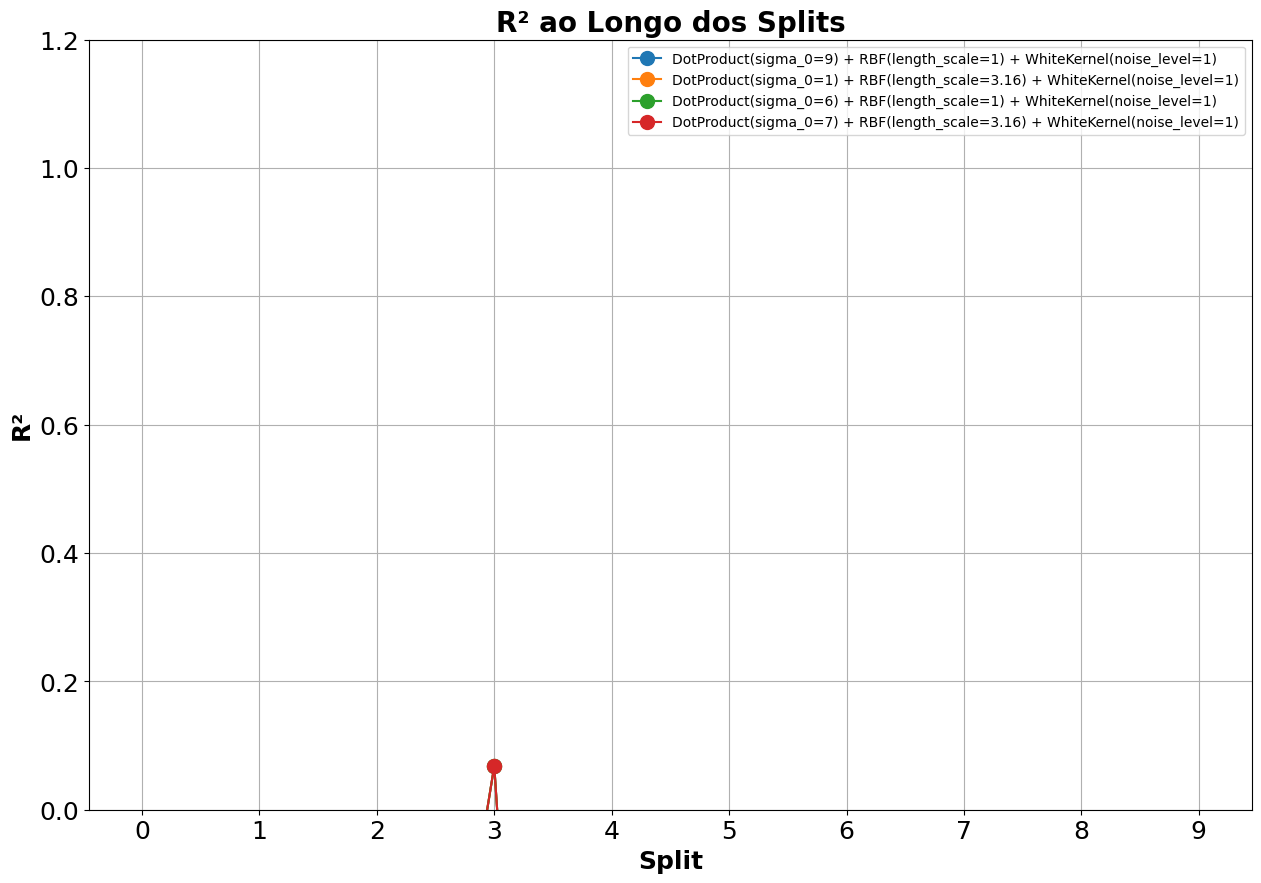

In [52]:
# Gráfico da evolução das métricas - r²
fig, ax = plt.subplots(figsize = (15,10))
for resultado in r2_results:
    ax.plot(splits,r2_results[resultado], marker = '.', markersize = 20, label = resultado)

plt.xticks(splits)  

ax.set_title('R² ao Longo dos Splits', fontweight = 'bold', fontsize = 20)
ax.set_xlabel('Split', fontweight = 'bold', fontsize = 18)
ax.set_ylabel('R²', fontweight = 'bold', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.grid()

ax.set_ylim([0, 1.2])
ax.legend()

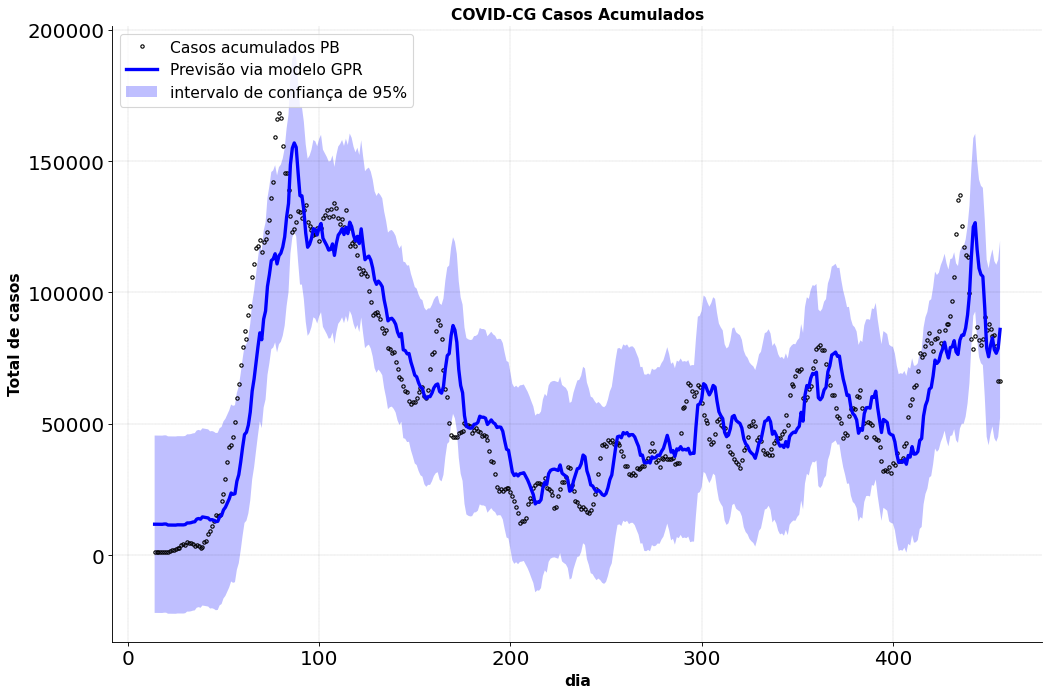

In [53]:
best_model = gsearch.best_estimator_
#Previsões do modelo

CRpred, sigma   = best_model.predict(X, return_std=True)    # previsão para todo o intervalo de dados
CRpred = np.ravel(CRpred)

# Obtendo a variável temporal
t = np.array(df['t'])
t = t.reshape(-1,1)

# Plotando as previsões do melhor modelo

plt.figure(1, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
mpl.style.use('default')
plt.plot(t, y*1000, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados PB')
plt.plot(t, CRpred*1000, 'b-', label='Previsão via modelo GPR', linewidth = 3)


plt.fill(np.concatenate([t, t[::-1]]),
        np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
                        (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
        alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
plt.legend(loc='upper left', fontsize = 14)
#plt.ylim(0, 100e3)
#plt.xlim(1, np.size(t) + 20)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Total de casos', fontsize = 14, fontweight = 'bold')
plt.xlabel('dia', fontsize = 14, fontweight = 'bold')
plt.title('COVID-CG Casos Acumulados', fontsize = 14, fontweight = 'bold')
plt.tick_params(axis='both', which='major', labelsize=18)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

## Trend, cyclical, irregular

In [44]:
# Regressão polinomial

trend_cyclical_kernels = []

## Linear -- Não estacionário
exp_sine_kernels = [ExpSineSquared(periodicity=p) for p in [1,3,7,10,15,30]]

#squared exponential

rational_quadratic_kernels = [RationalQuadratic(length_scale = l) for l in np.logspace(-1, 1, 10)]

noise_kernels = [WhiteKernel()]

for esk in exp_sine_kernels:
    for rqk in rational_quadratic_kernels:
        for nk in noise_kernels:
            trend_cyclical_kernels.append(esk + rqk + nk)

In [45]:
tscv = TimeSeriesSplit(n_splits=10)
model = GaussianProcessRegressor()
param_search = {'model__kernel': trend_cyclical_kernels, 'model__alpha': [1e-2]}

training_pipeline = Pipeline([('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'mape': 'neg_mean_absolute_percentage_error'}


gsearch = GridSearchCV(estimator=training_pipeline, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = 'R2')

In [46]:
gsearch.fit(X,y)

LinAlgError: ("The kernel, ExpSineSquared(length_scale=1, periodicity=1) + RationalQuadratic(alpha=1, length_scale=0.1) + WhiteKernel(noise_level=1), is not returning a positive definite matrix. Try gradually increasing the 'alpha' parameter of your GaussianProcessRegressor estimator.", '37-th leading minor of the array is not positive definite')

# Experimentando com a estrutura trend,cyclical, irregular

In [24]:
kernel = [RationalQuadratic()]

In [25]:
tscv = TimeSeriesSplit(n_splits=10)
model = GaussianProcessRegressor()
param_search = {'model__kernel': kernel, 'model__alpha': [1e-3]}

training_pipeline = Pipeline([('model', model)])

scoring = {'R2': 'r2', 'mse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'mape': 'neg_mean_absolute_percentage_error'}


gsearch = GridSearchCV(estimator=training_pipeline, cv=tscv, scoring=scoring,
                        param_grid=param_search, refit = 'R2')

In [27]:
gsearch.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('model', GaussianProcessRegressor())]),
             param_grid={'model__alpha': [0.001],
                         'model__kernel': [RationalQuadratic(alpha=1, length_scale=1)]},
             refit='R2',
             scoring={'R2': 'r2', 'mae': 'neg_mean_absolute_error',
                      'mape': 'neg_mean_absolute_percentage_error',
                      'mse': 'neg_root_mean_squared_error'})

In [31]:
results = pd.DataFrame(gsearch.cv_results_)
results = results.sort_values(by='rank_test_R2')
results.reset_index(inplace= True, drop = True)
results.head().T

,0
mean_fit_time,0.224574
std_fit_time,0.185943
mean_score_time,0.013556
std_score_time,0.012785
param_model__alpha,0.001
param_model__kernel,"RationalQuadratic(alpha=1, length_scale=1)"
params,"{'model__alpha': 0.001, 'model__kernel': Ratio..."
split0_test_R2,-14.280291
split1_test_R2,0.212575
split2_test_R2,-2.622124


In [37]:
train_df.shape

(456, 15)

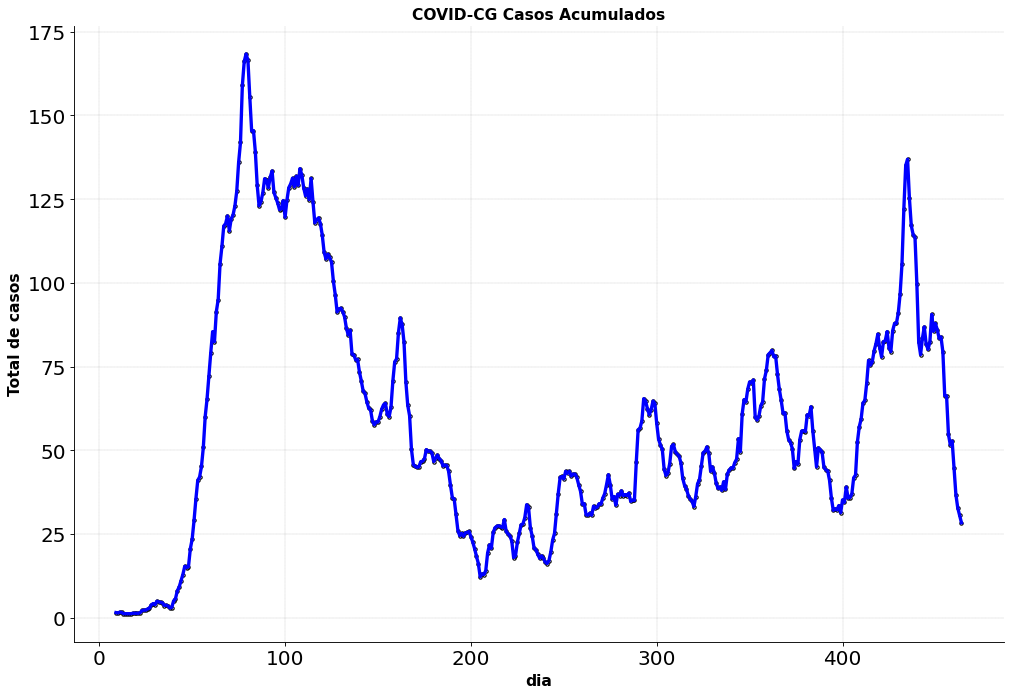

In [40]:
best_model = gsearch.best_estimator_
#Previsões do modelo

CRpred, sigma   = best_model.predict(X, return_std=True)    # previsão para todo o intervalo de dados
CRpred = np.ravel(CRpred)

# Obtendo a variável temporal
t = np.array(train_df['t'])
t = t.reshape(-1,1)

# Plotando as previsões do melhor modelo

plt.figure(1, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
mpl.style.use('default')
plt.plot(t, y, 'ko', markersize=3, mfc='none', linewidth=1, label=r'Casos acumulados PB')
plt.plot(t, CRpred, 'b-', label='Previsão via modelo GPR', linewidth = 3)


# plt.fill(np.concatenate([t, t[::-1]]),
#         np.concatenate([CRpred*1000 - 1.9600 * 1000*sigma,
#                         (CRpred*1000 + 1.9600 * 1000*sigma)[::-1]]),
#         alpha=.25, fc='b', ec='None', label='intervalo de confiança de 95%')
# plt.legend(loc='upper left', fontsize = 14)
#plt.ylim(0, 100e3)
#plt.xlim(1, np.size(t) + 20)
plt.grid(color='k', linestyle='--', linewidth=0.1)
plt.ylabel('Total de casos', fontsize = 14, fontweight = 'bold')
plt.xlabel('dia', fontsize = 14, fontweight = 'bold')
plt.title('COVID-CG Casos Acumulados', fontsize = 14, fontweight = 'bold')
plt.tick_params(axis='both', which='major', labelsize=18)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [ ]:
from prettytable import PrettyTable
def summaryResults(gsearch, modelname, granularity, ranking = True):
    # print(gsearch.cv_results_.keys())
    results = pd.DataFrame(gsearch.cv_results_)
    results.sort_values(by='rank_test_R2', inplace=True)
    results = results.reset_index(drop=True)
    
    t = PrettyTable()
    t.field_names = ["Item","Valor"]
    t.add_row(["Maior R2",np.max(results['mean_test_R2'])])
    t.add_row(["Menor R2",np.min(results['mean_test_R2'])])
    t.add_row(["Std R2", np.std(results['mean_test_R2'])])
    t.add_row(["Melhor MSE:", np.max(results['mean_test_mse'])])
    t.add_row(["Quantidade de modelos: ",len(results)])
    print(t.get_string(title="Summary for " + modelname + " @ " + granularity))
    
    t = PrettyTable()
    t.field_names = ["Ranking", "Parametros","R2-mean","R2-std", "MSE-mean", "MSE-std", "MAE-mean", "MAE-sts", "MAPE-mean", "MAPE-std"]
    names = ['params', 'mean_test_R2', 'std_test_R2','mean_test_mse', 'std_test_mse','mean_test_mae', 'std_test_mae', 'mean_test_mape', 'std_test_mape']
    t._max_width = {"Parametros":1}
    
    if not ranking:
        end = 1
    else:
        end = 3
    
    for i in range(0,end):
        lista = [i + 1]
        for n in names:
            lista.append(results.loc[i,n])
        t.add_row(lista)

    print(t.get_string(title="Top-3 " + modelname + " for " + granularity))
    
    t = PrettyTable()
    fields = []
    values = []
    for i in range(0,5):
        fname = 'split' + str(i)+'_test_R2'
        fields.append(fname)
        values.append(results.loc[0,fname])
        
    t.field_names = fields
    t.add_row(values)
    print(t)

In [ ]:
summaryResults(gsearch, 'gpr', 'cg')

+-----------------------------------------------+
|              Summary for gpr @ cg             |
+-------------------------+---------------------+
|           Item          |        Valor        |
+-------------------------+---------------------+
|         Maior R2        |  -2.759855714904698 |
|         Menor R2        |  -2.759855714904698 |
|          Std R2         |         0.0         |
|       Melhor MSE:       | -28.307954778738218 |
| Quantidade de modelos:  |          1          |
+-------------------------+---------------------+


KeyError: 1